In [1]:
!pip install tensorflow==2.0.0-rc2

     |████████████████████████████████| 86.3MB 68.9MB/s 
     |████████████████████████████████| 3.8MB 38.3MB/s 
     |████████████████████████████████| 501kB 39.5MB/s 
  Found existing installation: tensorboard 1.14.0
    Uninstalling tensorboard-1.14.0:
      Successfully uninstalled tensorboard-1.14.0
  Found existing installation: tensorflow 1.14.0
    Uninstalling tensorflow-1.14.0:
      Successfully uninstalled tensorflow-1.14.0


## Mixture Density Networks

This reproduces David Ha's blogpost in TensorFlow 2

http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/

In [0]:
import math

from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Concatenate, Dense, Input, Lambda

In [3]:
np.__version__

'1.16.5'

In [4]:
tf.__version__

'2.0.0-rc2'

In [0]:
NSAMPLE = 1000
NHIDDEN = 20

$$y = 7sin(0.75x) + 0.5x + \epsilon$$

In [0]:
x = 2 * math.pi * np.random.uniform(-1.5, 1.5, (NSAMPLE, 1)).astype(np.float32)

In [0]:
r = np.random.normal(size=(NSAMPLE, 1)).astype(np.float32)

In [0]:
y = (7.0 * np.sin(0.75 * x) + 0.5 * x + r).astype(np.float32)

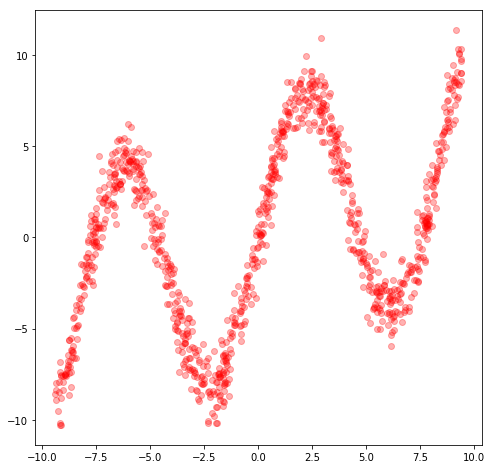

In [9]:
plt.figure(figsize=(8, 8))
plt.plot(x, y, "ro", alpha=0.3)

In [0]:
def create_model(h):
    x = inp = Input((1,))
    x = Dense(h, activation="tanh")(x)
    x = Dense(1, activation=None)(x)
    return Model(inp, x)

In [0]:
model = create_model(NHIDDEN)

In [0]:
model.compile(optimizer="rmsprop", loss="mse")

In [0]:
hist = model.fit(x, y, epochs=1500, verbose=0)

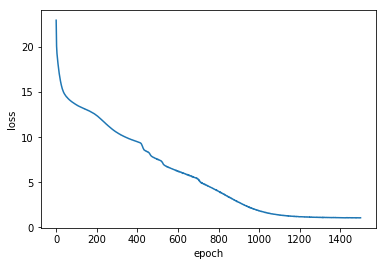

In [14]:
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(hist.history["loss"])

In [0]:
x_test = 2 * math.pi * np.arange(-1.5, 1.5, 0.01)
x_test = x_test.reshape(x_test.size, 1)

In [0]:
y_pred = model.predict(x_test)

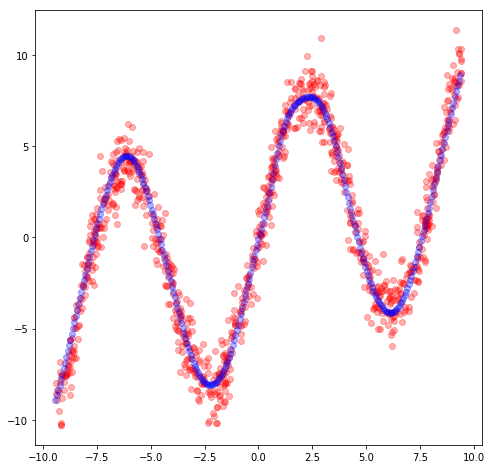

In [17]:
plt.figure(figsize=(8, 8))
plt.plot(x, y, "ro", x_test, y_pred, "bo", alpha=0.3)

Now, Invert the data, so that

$x = 7sin(0.75y) + 0.5y + \epsilon$

In [0]:
x, y = y, x

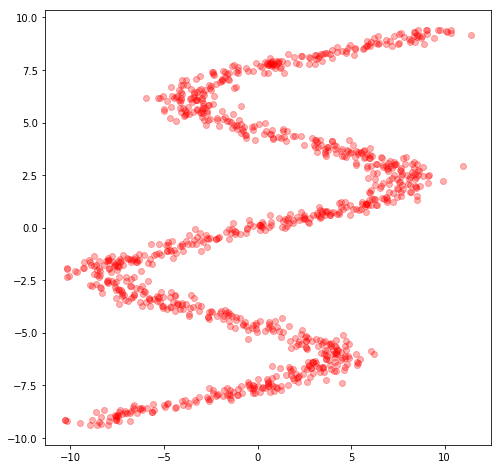

In [19]:
plt.figure(figsize=(8, 8))
plt.plot(x, y, "ro", alpha=0.3)

In [0]:
model = create_model(NHIDDEN)

In [0]:
model.compile(optimizer="sgd", loss="mse")

In [0]:
hist = model.fit(x, y, epochs=1500, verbose=0)

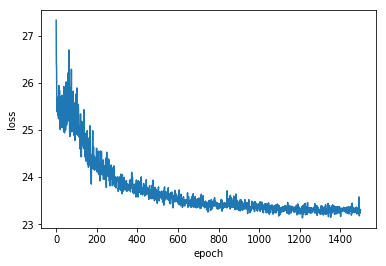

In [23]:
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(hist.history["loss"])

In [0]:
x_test = np.arange(-10, 10, 0.1)
x_test = x_test.reshape(x_test.size, 1)

In [0]:
y_pred = model.predict(x_test)

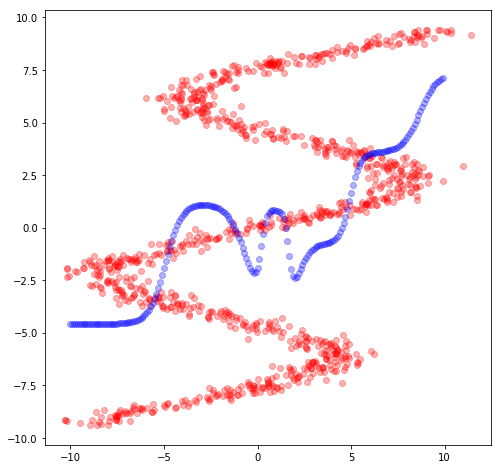

In [26]:
plt.figure(figsize=(8, 8))
plt.plot(x, y, "ro", x_test, y_pred, "bo", alpha=0.3)

The fundamental limitation is predicting only one value for an input, instead of a distribution

__Mixture Density Networks(MDNs)__ attempt to predict a probability distribution, instead of a single value for an input.

For each input $x$, we predict a pdf $P(Y=y|X=x)$

$$P(Y=y|X=x) = \sum_{k=0}^{k=K-1} \Pi_k(x) \phi(y, \mu_k(x), \sigma_k(x))$$

where

$$\sum_{k=0}^{k=K - 1}\Pi_k(x) = 1$$

- $\Pi$, $\phi$ and $\mu$ for each $k$ will be predicted using a model
- $\Pi$ add to 1 to ensure that the PDF aggregates to 100%
- $\sigma_k$ must be strictly positive

In [0]:
NSAMPLE = 2500
NHIDDEN = 24
NMIXTURES = 24

In [0]:
y = 2 * math.pi * np.random.uniform(-1.5, 1.5, (NSAMPLE, 1)).astype(np.float32)

In [0]:
r = np.random.normal(size=(NSAMPLE, 1)).astype(np.float32)

In [0]:
x = (7.0 * np.sin(0.75 * y) + 0.5 * y + r).astype(np.float32)

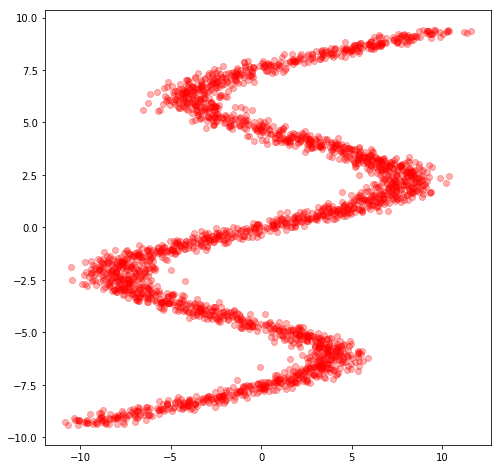

In [31]:
plt.figure(figsize=(8, 8))
plt.plot(x, y, "ro", alpha=0.3)

$$Z = W_otanh(W_hX + b_h) + b_o$$

Z will have `NMIXTURES` * 3 values

$$\Pi_k = \frac{exp(Z_k)}{\sum_{i=0}^{23}exp(Z_i)}$$

$$\sigma = exp(Z_{24-48})$$

$$\mu = Z_{48-71}$$

Least squares is inadequate, a better idea is to minimize the log likelihood of the distribution

$$Cost(y|x) = -log[\sum_k^K \Pi_k(x)\phi(y, \mu(x), \sigma(x))]$$

- The softmax ensures that $\Pi$ add to 1
- The `exp` ensures that the value is positive
- __NOTE:__ `tf.math.softmax` is used to calculate softmax, with the idea that it will take care of exploding `exp` problem

In [0]:
def extract_mixture_coef(t):
    a, b, c = t[:, :24], t[:, 24:48], t[:, 48:]
    a = tf.math.softmax(a)
    b = tf.math.exp(b)
    return a, b, c

def create_model():
    """
    NOTE: the outputs are concatenated and then split again when calculating loss
    because keras seems to expect multiple loss calculations for multiple outputs
    instead of passing them as y_pred in a single loss function
    """
    NOUT = NMIXTURES * 3
    x = inp = Input((1, ))
    x = Dense(NHIDDEN, activation="tanh")(x)
    x = Dense(NOUT, activation=None)(x)
    pi, sigma, mu = Lambda(extract_mixture_coef)(x)
    x = Concatenate(-1)([pi, sigma, mu])
    return Model(inputs=inp, outputs=x)

$$PDF = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x - \mu)^2}{2\sigma^2}}$$

In [0]:
class CustomLoss(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):
        """
        y_true: ([None, 1])
        y_pred: ([None, 72])
        """
        pi_pred, sigma_pred, mu_pred = y_pred[:, :24], y_pred[:, 24:48], y_pred[:, 48:]
        x = self.normal(y_true, mu_pred, sigma_pred)
        x = x * pi_pred
        x = tf.reduce_sum(x, axis=-1)
        x = -tf.math.log(x)
        return x
        
    def normal(self, x, mu, sigma):
        """
        https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Normal
        should be used here, but problems with installation
        """
        x = x - mu
        x = x / sigma
        x = -(x ** 2) / 2
        return tf.math.exp(x) / (sigma * tf.sqrt(2 * math.pi))

In [0]:
model = create_model()

In [0]:
model.compile(optimizer="sgd", loss=CustomLoss())

In [36]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 24)           48          input_3[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 72)           1800        dense_4[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 ((None, 24), (None,  0           dense_5[0][0]                    
____________________________________________________________________________________________

In [0]:
hist = model.fit(x, y, epochs=5000, verbose=0)

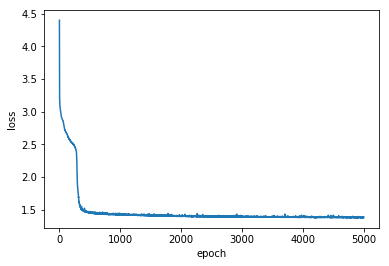

In [38]:
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(hist.history["loss"])

__NOTE:__ There still does not seem to be a way to apply the gradient optimizations provided in the Bishop paper without implementing custom C++ ops. However, Swift seems to provide a way to specify a custom function for computing gradient. https://www.tensorflow.org/swift/tutorials/custom_differentiation

PyTorch also allows putting in a custom autograd backward function https://pytorch.org/tutorials/beginner/examples_autograd/two_layer_net_custom_function.html

For prediction, we select a distribution based on $\Pi$ probabilities, then from each distribution, we sample points to produce ensembles.

In [0]:
x_test = np.arange(-10, 10, 0.1).astype(np.float32)
x_test = np.expand_dims(x_test, -1)

In [0]:
y_pred = model.predict(x_test)

In [0]:
pi_pred, sigma_pred, mu_pred = y_pred[:, :24], y_pred[:, 24:48], y_pred[:, 48:]

In [0]:
def generate_ensemble(pi, mu, sigma, M=10):
    N = pi.shape[0]
    result = np.zeros((N, M))
    r = np.random.randn(N, M)

    for i in range(N):
        for j in range(M):
            p = np.random.choice(NMIXTURES, p=pi[i])
            m = mu[i, p]
            s = sigma[i, p]
            result[i, j] = m + r[i, j] * s

    return result

In [0]:
res = generate_ensemble(pi_pred, mu_pred, sigma_pred)

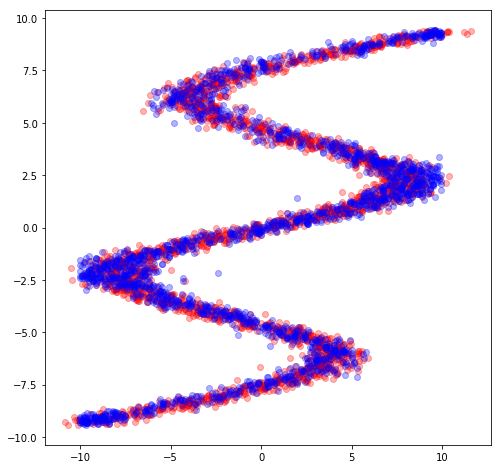

In [44]:
plt.figure(figsize=(8, 8))
plt.plot(x, y, "ro", x_test, res, "bo", alpha=0.3)

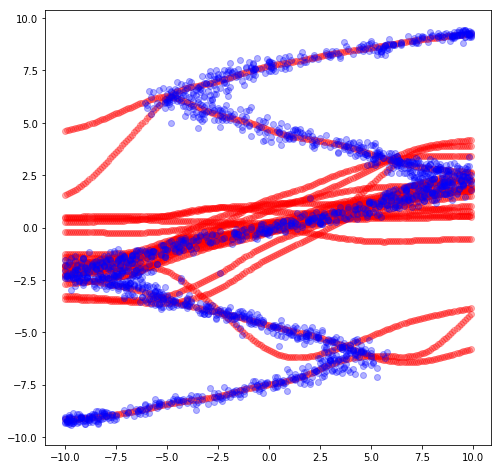

In [45]:
plt.figure(figsize=(8, 8))
plt.plot(x_test, mu_pred, "ro", x_test, res, "bo", alpha=0.3)

In [0]:
x_ = np.arange(-10, 10, 0.1).astype(np.float32)
y_ = np.arange(-10, 10, 0.1).astype(np.float32)

In [0]:
def normal(x, mu, sigma):
    x = x - mu
    x = x / sigma
    x = -(x ** 2) / 2
    return np.exp(x) / (sigma * np.sqrt(2 * math.pi))

In [0]:
def generate_heatmap(pi, mu, sigma, x, y):
    N = x.size
    M = y.size

    z = np.zeros((M, N))

    for k in range(NMIXTURES):
        for i in range(N):
            m = mu[i, k]
            s = sigma[i, k]
            p = pi[i, k]

            for j in range(M):
                z[M - 1 - j, i] += p * normal(y[j], m, s)

    return z

In [0]:
h = generate_heatmap(pi_pred, mu_pred, sigma_pred, x_, y_)

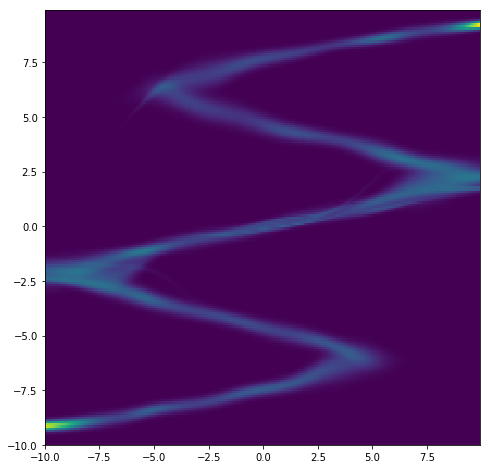

In [50]:
extent = [x_[0], x_[-1], y_[0], y_[-1]]
plt.figure(figsize=(8, 8))
plt.imshow(h, extent=extent)
plt.show()